In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from pathlib import Path

path = str(Path().resolve())
path = path + "\\ADNI_PROCESSED"

def apply_mask(img_n_mmni, img_mask):
    """
        Taking a n_mmni and apply the correspondant mask
        param:
            img_n_mmi   : image n_mmi
            img_mask    : mask
    """
    mmni_m = img_n_mmni.get_fdata()
    mask_m = img_mask.get_fdata().astype(bool)
    mask_bg = np.logical_not(mask_m)
    mmni_m[mask_bg] = 0
    return mmni_m

def process_irm_data():
    """
        Create a new directory and process all images from tha ADNI1 directory
    """
    path = str(Path().resolve())
    path_res = path + "\\ADNI_PROCESSED"
    Path(path_res).mkdir(parents=True, exist_ok=True) # Create a directory for data processed
    path = path + "\\ADNI1"
    for filename in os.listdir(path):
        if filename.startswith("n_mmni"):
            n_mmni_filename = os.path.join(path, filename)
            mask_filename = os.path.join(path, "mask_" + filename)
            img_n_mmni = nib.load(n_mmni_filename)
            img_mask = nib.load(mask_filename)
            n_mmni_mask = apply_mask(img_n_mmni, img_mask)
            img = nib.Nifti1Image(n_mmni_mask, np.eye(4))
            nib.save(img, os.path.join(path_res, filename))

# process_irm_data()

In [2]:
def load_processed_data(path):
    """
        load all n_mmni found in the path
    """
    if not os.path.isdir(path):
        print("Can't found directory: " + path)
    else:
        list_x = []
        for filename in os.listdir(path):
            n_mmni_filename = os.path.join(path, filename)
            img_n_mmni = nib.load(n_mmni_filename)
            mmni_matrix = img_n_mmni.get_fdata()
            list_x.append((filename, mmni_matrix))
        return list_x

In [3]:
def cut_2D_i(img_n_mmni, axe, idx):
    """
        Function that returns a 2D cut from the "img" in the index "idx", along the axe given in parameter
    """
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim[axe] <= idx or idx < 0:
        print("Invalid value for index must be between 0 and " , axe_dim[axe])
        return
    if axe == "x":
        cropped_img = img_n_mmni.slicer[idx:idx+1, ...]
    elif axe == "y":
        cropped_img = img_n_mmni.slicer[45:145, idx:idx+1,35:135]
    elif axe == "z":
        cropped_img = img_n_mmni.slicer[..., idx:idx+1]
    else:
        print("Choose a valid value for axe: x, y or z")
    return cropped_img

def patch_3D(img_n_mmni, axe, idx_start, idx_end):
    """
        Function that returns a 3D patch from the "img" along the axe given in parameter, from the idx_start to idx_end
    """
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim[axe] <= idx_start or idx_start < 0 or axe_dim[axe] <= idx_end or idx_end < 0 or idx_start >= idx_end:
        print("Invalid value for index must, values must be between 0 and " , axe_dim[axe], "and idx_start must be greater than idx_end")
        return
    if axe == "x":
        cropped_img = img_n_mmni.slicer[idx_start:idx_end, ...]
    elif axe == "y":
        cropped_img = img_n_mmni.slicer[:, idx_start:idx_end,:]
    elif axe == "z":
        cropped_img = img_n_mmni.slicer[..., idx_start:idx_end]
    else:
        print("Choose a valid value for axe: x, y or z")
    return cropped_img

# To test thid function
n_mmni_filename = os.path.join(path, "n_mmni_fADNI_002_S_0295_1.5T_t1w.nii.gz")
img_n_mmni = nib.load(n_mmni_filename)
crop_img = cut_2D_i(img_n_mmni, "y", 95)
img_data = crop_img.get_fdata()
print(img_data.shape)
img_data = np.transpose(img_data, (0, 2, 1))
print(img_data.shape)
crop_img = nib.Nifti1Image(img_data, np.eye(4))
nib.save(crop_img, 'test_img.nii')

(100, 1, 100)
(100, 100, 1)


In [4]:
def load_X_data(path):
    if not os.path.isdir(path):
        print("Can't found directory: " + path)
    else:
        list_x = []
        for filename in os.listdir(path):
            n_mmni_filename = os.path.join(path, filename)
            img_n_mmni = nib.load(n_mmni_filename)
            # Customize your choice: taking a 2D cuts or 3D patches
            cropped_img = cut_2D_i(img_n_mmni, "y", 106)
            cropped_n_mmni_matrix = cropped_img.get_fdata()
            list_x.append((filename, cropped_n_mmni_matrix))
        return list_x

# X_data = load_X_data(path)

In [5]:
import os
import re
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

def load_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[(data.Group == 'CN') | (data.Group == 'AD')]
    return data

path = str(Path().resolve())
path = path + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = load_data(path)
y_data.head(7)

,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [6]:
from keras.utils.np_utils import to_categorical
usecols = ['Subject ID', 'Rooster ID', 'Group']
# ['CN', 'AD']
def prepare_X_of_Y(Y):
    X_data = []
    Y_data = []
    X_test_index = []
    Y_test = []
    path = str(Path().resolve())
    path += "\\ADNI_PROCESSED"
    n_test_AD = 0
    n_test_CN = 0
    for index, row in Y.iterrows():
        file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            # Taking 4 images for test purpose
            if (Y['Group'][index] == 'AD' and n_test_AD < 2) or (Y['Group'][index] == 'CN' and n_test_CN < 2):
                n_test_AD += 1 if Y['Group'][index] == 'AD' else n_test_AD
                n_test_CN += 1 if Y['Group'][index] == 'CN' else n_test_CN
                X_test_index.append(index)
            else:
                for i in range(101, 107):
                    crop_img = cut_2D_i(img_n_mmni, "y", i)
                    img_data = crop_img.get_fdata()
                    img_data = np.transpose(img_data, (0, 2, 1))/255.0
                    X_data.append(img_data)
                    if Y['Group'][index] == 'AD':
                        Y_data.append(1)
                    elif Y['Group'][index] == 'CN':
                        Y_data.append(0)
        else:
            Y.drop(index, inplace=True)
    return np.array(X_data), Y_data, X_test_index

X_data, Y_data_list, X_test_index = prepare_X_of_Y(y_data)
Y_data = to_categorical(Y_data_list, num_classes=2)
len(X_data) == len(Y_data)

True

{0: 'CN', 1: 'AD'}


C:\Users\fayco\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


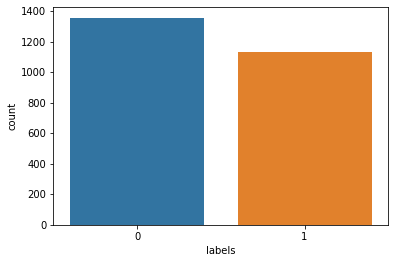

In [7]:
map_characters = {0: 'CN', 1: 'AD'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"] = Y_data_list
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

# U-Net Neural Network

Creation of two U-Net models:
* One for 2D inputs, in case we slice the input into 2D images.
* The other for 3D inputs, in case we use 3D blocs of the image.

In [8]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_Unet_model2D(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    encode_layers_list = []
    for i in range(depth):
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)
        if i != depth - 1:
            encode_layers_list.append(x)
            x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
            num_filters *= 2
    
    for i in range(depth - 1):
        x = UpSampling2D()(x)
        x = Conv2D(filters=num_filters, kernel_size=(2,2), padding='same', activation='relu')(x)
        #cropping
        encoder_shape = encode_layers_list[depth - 2 - i].shape
        decoder_shape = x.shape
        shape_diff = (encoder_shape[1] - decoder_shape[1], encoder_shape[2] - decoder_shape[2])
        xshape_diff = shape_diff[0] // 2
        yshape_diff = shape_diff[1] // 2
        if shape_diff[0] % 2 != 0:
            xshape_diff = (shape_diff[0] // 2, shape_diff[0] // 2 + 1)
        if shape_diff[1] % 2 != 0:
            yshape_diff = (shape_diff[1] // 2, shape_diff[1] // 2 + 1)
        croped_layer = Cropping2D(cropping=(xshape_diff, yshape_diff))(encode_layers_list[depth - 2 - i])
        
        x = concatenate([croped_layer, x])
        num_filters /= 2
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)

    outputs = Conv2D(filters=2, padding=padding, kernel_size=(1,1))(x)
        
    return Model(inputs, outputs)

def create_Unet_model3D(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    encode_layers_list = []
    for i in range(depth):
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        if i != depth - 1:
            encode_layers_list.append(x)
            x = MaxPooling3D(pool_size=(2,2,2), strides=2)(x)
            num_filters *= 2
    

    for i in range(depth - 1):
        x = UpSampling3D()(x)
        x = Conv3D(filters=num_filters, kernel_size=(2,2,2), activation='relu', padding='same')(x)
        #cropping
        encoder_shape = encode_layers_list[depth - 2 - i].shape
        decoder_shape = x.shape
        shape_diff = (encoder_shape[1] - decoder_shape[1], encoder_shape[2] - decoder_shape[2], encoder_shape[3] - decoder_shape[3])
        xshape_diff = shape_diff[0] // 2
        yshape_diff = shape_diff[1] // 2
        zshape_diff = shape_diff[2] // 2
        if shape_diff[0] % 2 != 0:
            xshape_diff = (shape_diff[0] // 2, shape_diff[0] // 2 + 1)
        if shape_diff[1] % 2 != 0:
            yshape_diff = (shape_diff[1] // 2, shape_diff[1] // 2 + 1)
        if shape_diff[2] % 2 != 0:
            zshape_diff = (shape_diff[2] // 2, shape_diff[2] // 2 + 1)
        croped_layer = Cropping3D(cropping=(xshape_diff, yshape_diff, zshape_diff))(encode_layers_list[depth - 2 - i])

        x = concatenate([croped_layer, x])
        num_filters /= 2
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)

    outputs = Conv3D(filters=2, kernel_size=(1,1,1))(x)
        
    return Model(inputs, outputs)

def create_Unet_model2D_encoder(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    for i in range(depth):
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i != depth - 1:
            x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
            num_filters *= 2

    # Flattenting
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

def create_Unet_model3D_encoder(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    for i in range(depth):
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        if i != depth - 1:
            x = MaxPooling3D(pool_size=(2,2,2), strides=2)(x)
            num_filters *= 2

In [9]:
model_2 = create_Unet_model2D_encoder(X_data[0].shape, depth=4)
# model_2.compile(optimizer='adam', loss='squared_hinge', metrics=['accuracy'])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 98, 98, 64)        137       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 96, 96, 64)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 64)        0     

In [10]:
import tensorflow as tf
y = np.array([y[1] for y in Y_data])
x = np.array([tf.image.grayscale_to_rgb(tf.convert_to_tensor(img), name=None) for img in X_data])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_data, y, test_size=0.25,random_state=42)
print("Data splited")

Data splited


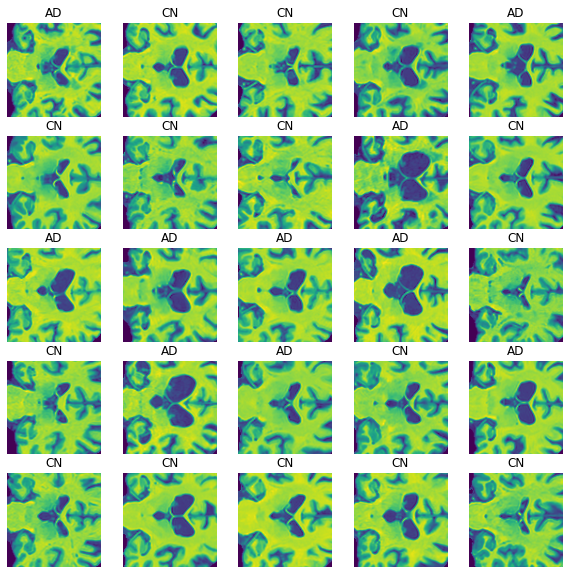

In [12]:
import matplotlib.pyplot as plt
def show_batch(image_batch, label_X):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_X[n]:
            plt.title("AD")
        else:
            plt.title("CN")
        plt.axis("off")
show_batch(X_val, Y_val)

In [13]:
model_2.fit(X_train, Y_train, epochs= 20, validation_data=(X_val,Y_val))

Epoch 1/20
59/59 [==============================] - 78s 1s/step - loss: 0.5187 - accuracy: 0.7300 - val_loss: 0.7053 - val_accuracy: 0.4430
Epoch 2/20
59/59 [==============================] - 72s 1s/step - loss: 0.2936 - accuracy: 0.8811 - val_loss: 0.7580 - val_accuracy: 0.4430
Epoch 3/20
59/59 [==============================] - 72s 1s/step - loss: 0.1353 - accuracy: 0.9582 - val_loss: 0.8659 - val_accuracy: 0.4430
Epoch 4/20
59/59 [==============================] - 72s 1s/step - loss: 0.0632 - accuracy: 0.9759 - val_loss: 1.3276 - val_accuracy: 0.4430
Epoch 5/20
59/59 [==============================] - 72s 1s/step - loss: 0.0633 - accuracy: 0.9759 - val_loss: 2.1144 - val_accuracy: 0.4430
Epoch 6/20
59/59 [==============================] - 72s 1s/step - loss: 0.0488 - accuracy: 0.9834 - val_loss: 3.1346 - val_accuracy: 0.4430
Epoch 7/20
59/59 [==============================] - 72s 1s/step - loss: 0.0391 - accuracy: 0.9871 - val_loss: 4.1132 - val_accuracy: 0.4430
Epoch 8/20
59/59 [==

IRM Correspond to : CN, Prediction: 1.9315332174301147% AD
IRM Correspond to : CN, Prediction: 0.00018165530946134822% AD
IRM Correspond to : AD, Prediction: 99.99832510948181% AD
IRM Correspond to : AD, Prediction: 0.00023289262571779545% AD


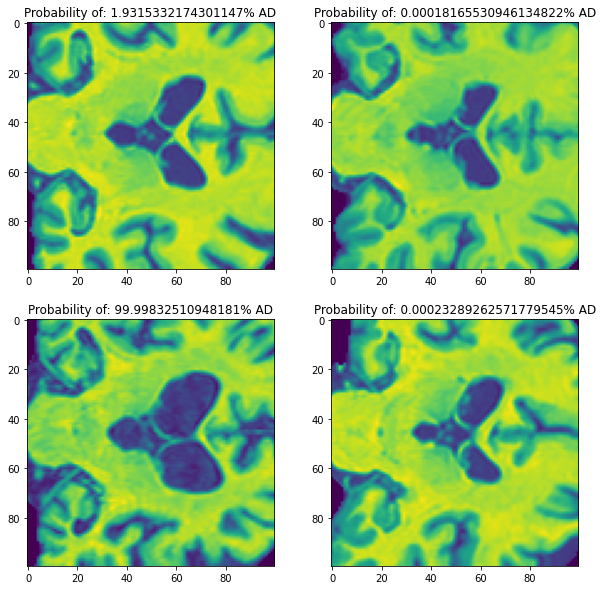

In [27]:
final_test_X = []
path = str(Path().resolve())
path = path + "\\ADNI_PROCESSED"
for index in X_test_index:
    file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
    if os.path.isfile(file):
        img_n_mmni = nib.load(file)
        crop_img = cut_2D_i(img_n_mmni, "y", 104)
        img_data = crop_img.get_fdata()
        img_data = np.transpose(img_data, (0, 2, 1))/255.0
        final_test_X.append(img_data)
final_test_X = np.array(final_test_X)
y_pred = model_2.predict(final_test_X)
plt.figure(figsize=(10,10))
for n in range(len(X_test_index)):
    ax = plt.subplot(2,2,n+1)
    plt.imshow(final_test_X[n])
    title = "Probability of: " + str(y_pred[n][0]*100) + "% AD"
    plt.title(title)

for n in range(len(X_test_index)):
    print("IRM Correspond to : " + y_data['Group'][X_test_index[n]] + ", Prediction: " + str(y_pred[n][0]*100) + "% AD")